In [5]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [6]:
# Define the sample data generation function
def generate_sample_data(mean, covariance, num_samples):
    X = torch.normal(0.0, 1, (num_samples, 2))
    A = torch.tensor(covariance)
    b = torch.tensor(mean)
    data = torch.matmul(X, A) + b
    return data

In [7]:
# Define the dataset class
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

# Define the Generator and Discriminator networks
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
        )

    def forward(self, x):
        return self.model(x)


In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [9]:
# Define the training function
def train(net_D, net_G, data_loader, num_epochs, lr_D, lr_G, latent_dim):
    criterion = nn.BCELoss()
    optimizer_D = torch.optim.Adam(net_D.parameters(), lr=lr_D)
    optimizer_G = torch.optim.Adam(net_G.parameters(), lr=lr_G)

    for epoch in range(num_epochs):
        loss_D_total, loss_G_total = 0, 0
        for data in data_loader:
            batch_size = data.shape[0]
            real_labels = torch.ones(batch_size, 1)
            fake_labels = torch.zeros(batch_size, 1)

            # Train Discriminator
            optimizer_D.zero_grad()
            real_output = net_D(data)
            noise = torch.randn(batch_size, latent_dim)
            fake_data = net_G(noise)
            fake_output = net_D(fake_data.detach())
            loss_D = criterion(real_output, real_labels) + criterion(fake_output, fake_labels)
            loss_D.backward()
            optimizer_D.step()
            loss_D_total += loss_D.item()

            # Train Generator
            optimizer_G.zero_grad()
            fake_output = net_D(fake_data)
            loss_G = criterion(fake_output, real_labels)
            loss_G.backward()
            optimizer_G.step()
            loss_G_total += loss_G.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Discriminator Loss: {loss_D_total/len(data_loader):.4f}, Generator Loss: {loss_G_total/len(data_loader):.4f}")


In [10]:
# Generate sample data
mean = [1, 2]
covariance = [[1, 2], [-0.1, 0.5]]
num_samples = 2000
data = generate_sample_data(mean, covariance, num_samples)

# Create dataset and dataloader
train_dataset = CustomDataset(data)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define hyperparameters
lr_D = 0.0002
lr_G = 0.0002
latent_dim = 64
num_epochs = 50

# Initialize Generator and Discriminator
net_G = Generator(latent_dim)
net_D = Discriminator()


Epoch [1/50], Discriminator Loss: 1.2776, Generator Loss: 0.7302
Epoch [2/50], Discriminator Loss: 1.3095, Generator Loss: 0.7387
Epoch [3/50], Discriminator Loss: 1.2630, Generator Loss: 0.9772
Epoch [4/50], Discriminator Loss: 1.2611, Generator Loss: 0.7480
Epoch [5/50], Discriminator Loss: 1.0461, Generator Loss: 0.8455
Epoch [6/50], Discriminator Loss: 0.8457, Generator Loss: 1.1509
Epoch [7/50], Discriminator Loss: 1.4786, Generator Loss: 0.8482
Epoch [8/50], Discriminator Loss: 1.4496, Generator Loss: 0.8937
Epoch [9/50], Discriminator Loss: 1.3404, Generator Loss: 0.7908
Epoch [10/50], Discriminator Loss: 1.2824, Generator Loss: 0.7582
Epoch [11/50], Discriminator Loss: 1.2349, Generator Loss: 0.8255
Epoch [12/50], Discriminator Loss: 1.2226, Generator Loss: 0.8581
Epoch [13/50], Discriminator Loss: 1.2633, Generator Loss: 0.7749
Epoch [14/50], Discriminator Loss: 1.3522, Generator Loss: 0.7109
Epoch [15/50], Discriminator Loss: 1.4475, Generator Loss: 0.6960
Epoch [16/50], Disc

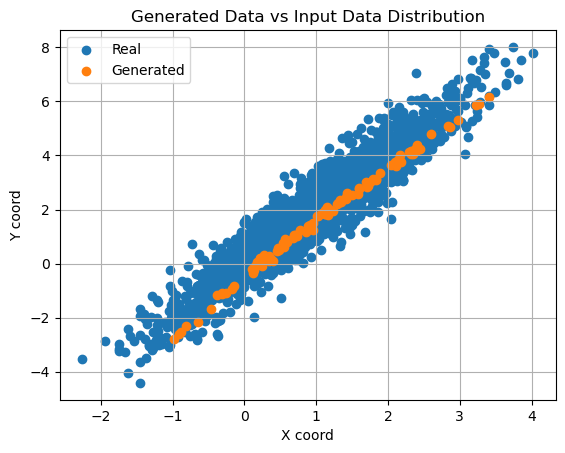

In [11]:
# Train the GAN
train(net_D, net_G, train_loader, num_epochs, lr_D, lr_G, latent_dim)

# Generate and visualize fake samples
with torch.no_grad():
    noise = torch.randn(100, latent_dim)
    fake_data = net_G(noise).numpy()

plt.figure()
plt.scatter(data[:, 0], data[:, 1], label="Real")
plt.scatter(fake_data[:, 0], fake_data[:, 1], label="Generated")
plt.xlabel("X coord")
plt.ylabel("Y coord")
plt.title("Generated Data vs Input Data Distribution")
plt.legend()
plt.grid(True)
plt.show()

